In [1]:
# Imports
# msticpy imports
from msticpy.nbtools.timeseries import display_timeseries_anomolies

# pandas
import pandas as pd

# stats library to calculate z-score
from scipy import stats

# statsmodels to use STL for time series decomposition
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL

# matplotlib plots for visualization
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rc('figure',figsize=(28,12))
plt.rc('font',size=14)

# For widescreen view
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>")) 

In [2]:
# using Pandas read_csv to read local .csv file containing trading data
df = pd.read_csv('data.csv')

In [3]:
# show sample records
df.head(10)

,Trader,Asset Name,Status,Trade Type,Payout,Investment,Trader Profit,Trading Strike,Close Strike,Trading Time,Close Time
0,trader C,AUD/USD,Closed,Put,1.85,1000,-1000.00,0.69676,0.69724,2020-06-10 03:00:01.760,2020-06-10 03:05:00.000
1,trader C,EUR/JPY,Closed,Call,1.85,10000,8500.00,116.35500,116.36400,2020-04-27 02:30:01.370,2020-04-27 02:35:00.000
2,trader C,EUR/USD,Closed,Call,1.85,5000,-5000.00,1.09412,1.09378,2020-04-15 07:45:01.810,2020-04-15 07:50:00.000
3,trader C,EUR/JPY,Closed,Call,1.95,1000,950.00,119.69900,119.71600,2019-09-13 18:57:25.390,2019-09-13 18:58:25.390
4,trader C,EUR/USD,Closed,Put,1.85,1000,-1000.00,1.21202,1.21202,2020-12-03 02:55:00.520,2020-12-03 03:00:00.000
5,trader A,BITCOIN,Closed,Put,2.05,4549,4776.45,37689.70000,37671.80000,2021-06-18 09:26:55.270,2021-06-18 09:29:55.270
6,trader C,EUR/AUD,Closed,Call,1.85,1000,850.00,1.62288,1.62319,2020-11-30 12:40:04.650,2020-11-30 12:45:00.000
7,trader C,EUR/AUD,Closed,Put,1.85,10050,8542.50,1.72604,1.72598,2020-04-21 09:30:00.520,2020-04-21 09:30:00.520
8,trader C,EUR/JPY,Closed,Call,1.90,1000,-1000.00,116.97300,116.96300,2020-04-02 19:06:15.650,2020-04-02 19:09:15.650
9,trader C,AUD/USD,Closed,Call,1.90,1200,1080.00,0.77320,0.77323,2021-04-16 04:51:01.050,2021-04-16 04:52:01.050


In [4]:
# check the number of traders in this dataset
df['Trader'].value_counts()

trader C    3242
trader A     100
trader B      29
trader E      28
Name: Trader, dtype: int64

In [5]:
# for a better analysis of the dataset and the best anomaly search, 
# it should be divided into subdatasets for each trader
dfa = df[df['Trader'] == 'trader A']
dfb = df[df['Trader'] == 'trader B']
dfc = df[df['Trader'] == 'trader C']
dfe = df[df['Trader'] == 'trader E']

In [6]:
# aggregate and sum of trader profit for each one
dfa_ts_agg = dfa.groupby(['Trading Time', 'Trader'])['Trader Profit'].sum().reset_index()
dfa_ts_agg = dfa_ts_agg[['Trading Time', 'Trader Profit']].set_index('Trading Time')

In [7]:
dfb_ts_agg = dfb.groupby(['Trading Time', 'Trader'])['Trader Profit'].sum().reset_index()
dfb_ts_agg = dfb_ts_agg[['Trading Time', 'Trader Profit']].set_index('Trading Time')

In [8]:
dfc_ts_agg = dfc.groupby(['Trading Time', 'Trader'])['Trader Profit'].sum().reset_index()
dfc_ts_agg = dfc_ts_agg[['Trading Time', 'Trader Profit']].set_index('Trading Time')

In [9]:
dfe_ts_agg = dfe.groupby(['Trading Time', 'Trader'])['Trader Profit'].sum().reset_index()
dfe_ts_agg = dfe_ts_agg[['Trading Time', 'Trader Profit']].set_index('Trading Time')

<AxesSubplot:>

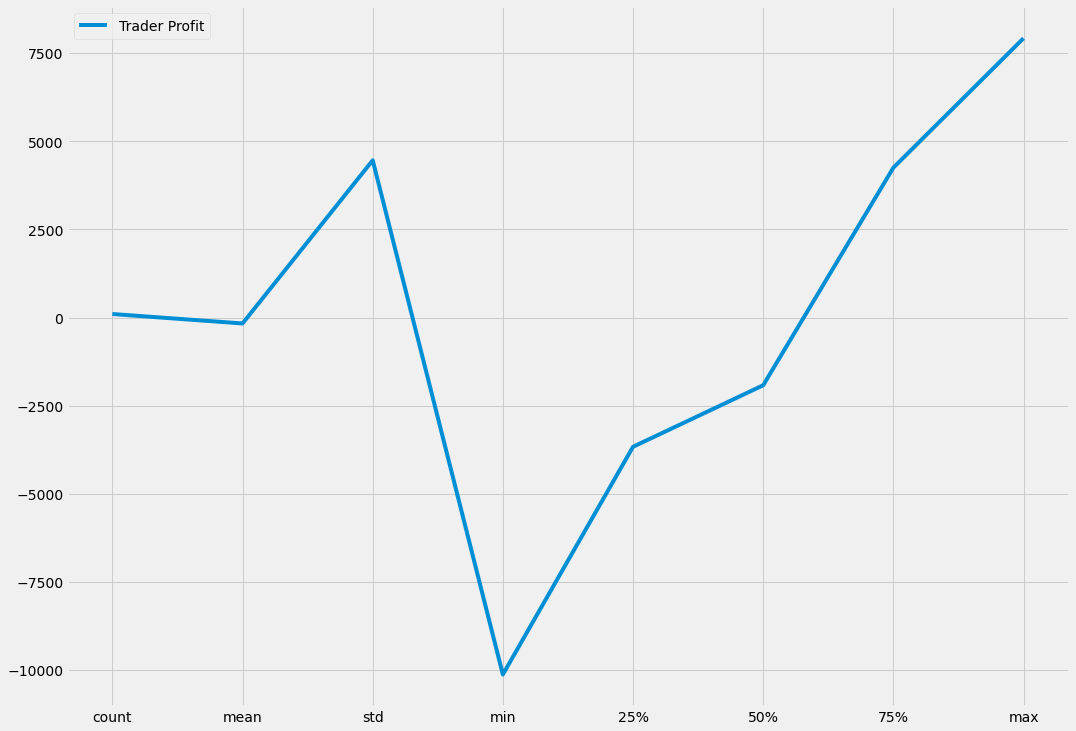

In [10]:
dfa_ts_agg.describe().plot()

<AxesSubplot:>

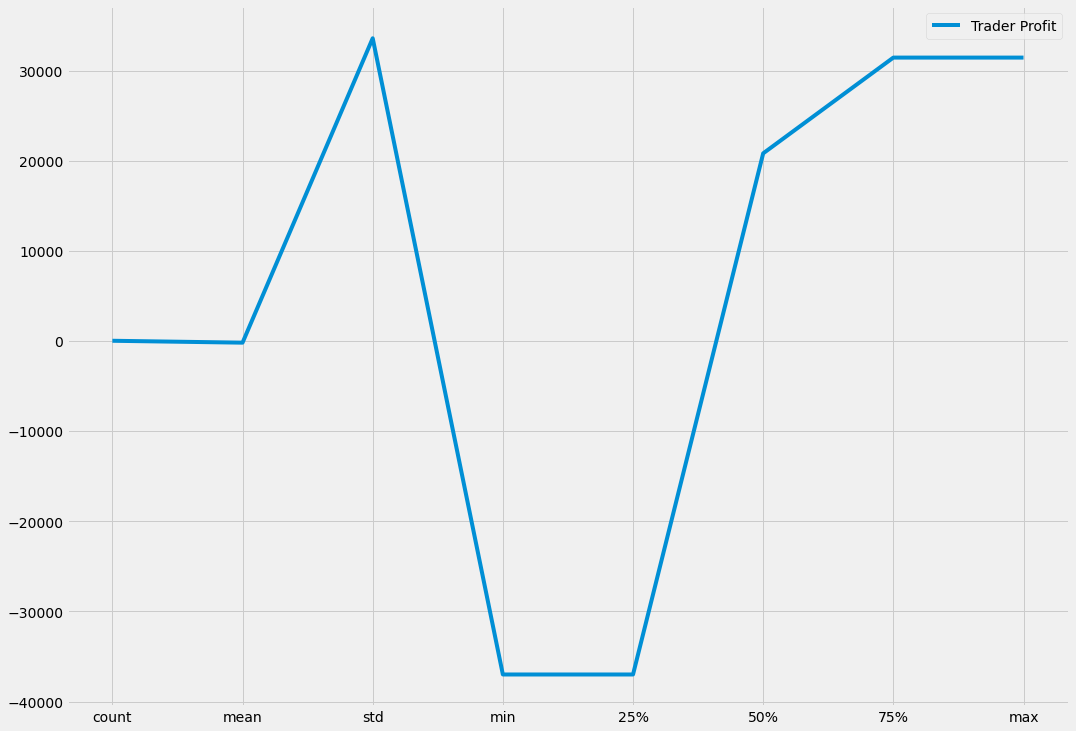

In [11]:
dfb_ts_agg.describe().plot()

<AxesSubplot:>

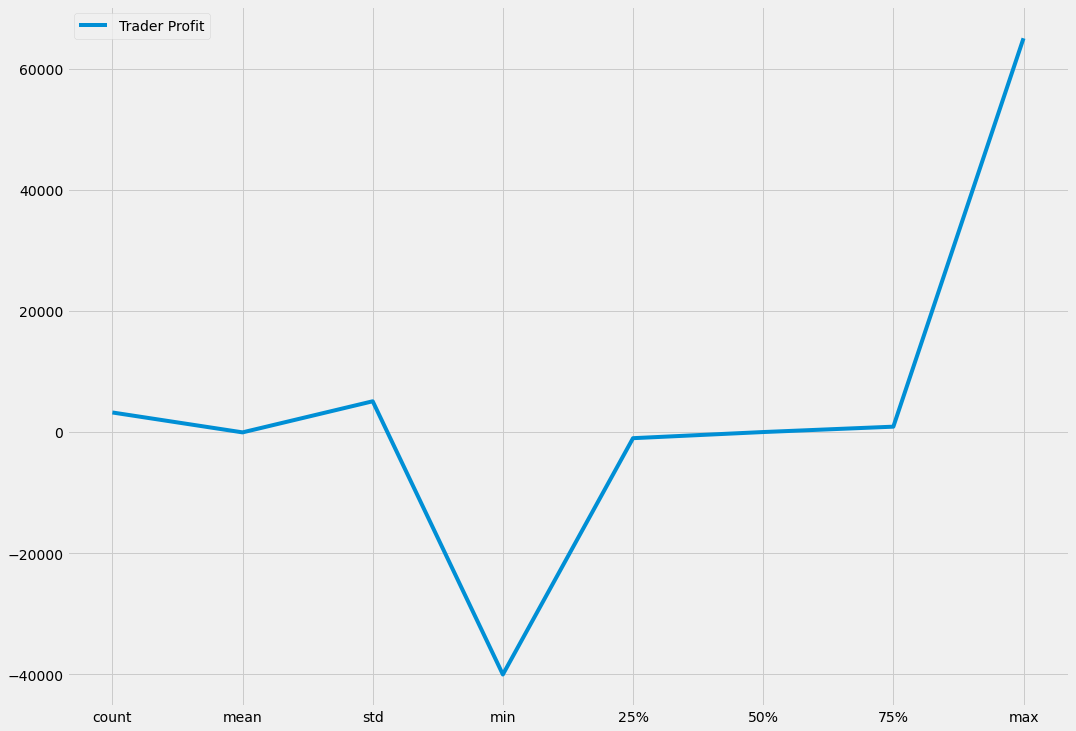

In [12]:
dfc_ts_agg.describe().plot()

<AxesSubplot:>

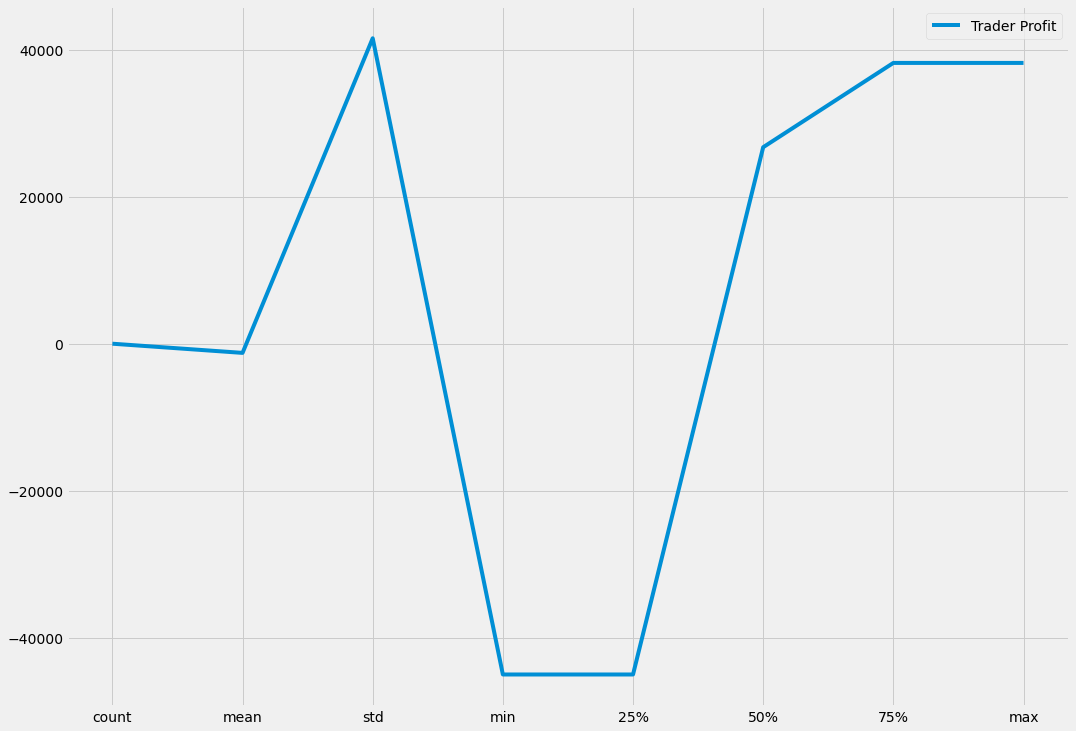

In [13]:
dfe_ts_agg.describe().plot()

In [14]:
from statsmodels.tsa.seasonal import STL

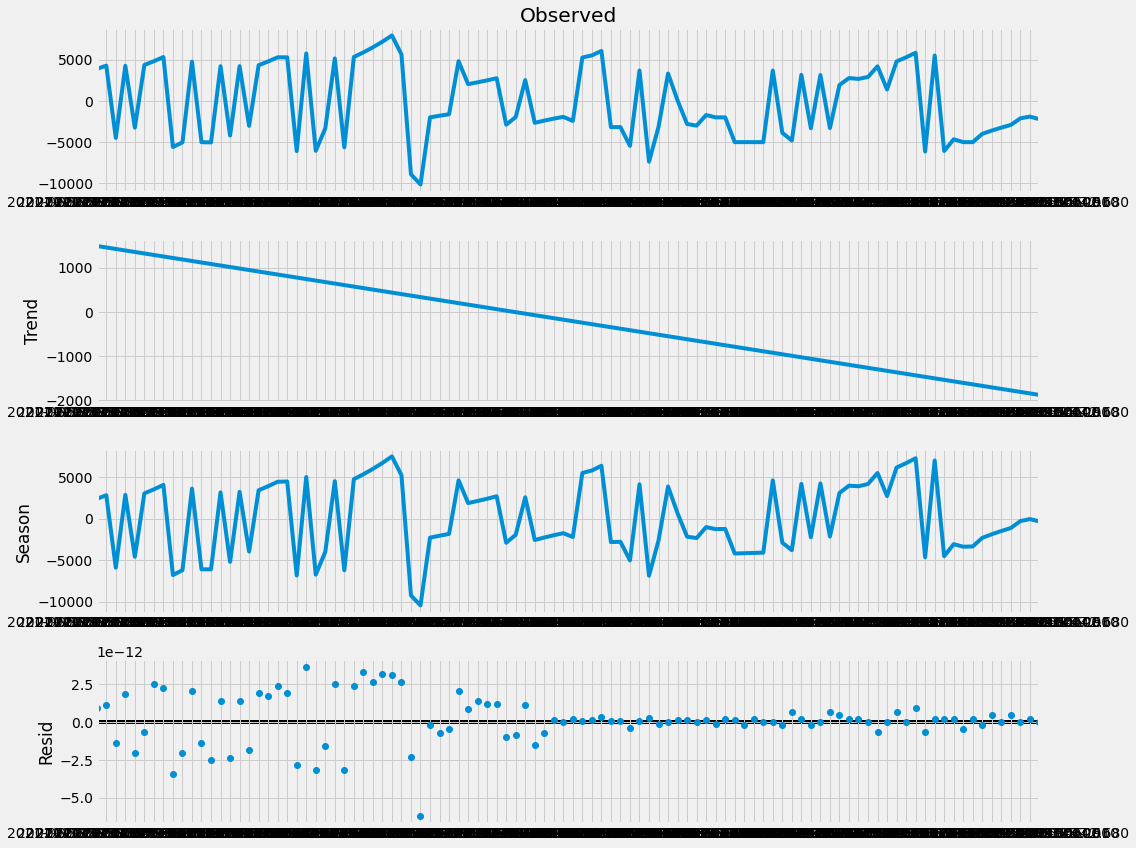

In [15]:
a_stl = STL(dfa_ts_agg, period=52)
res = a_stl.fit()
fig = res.plot()

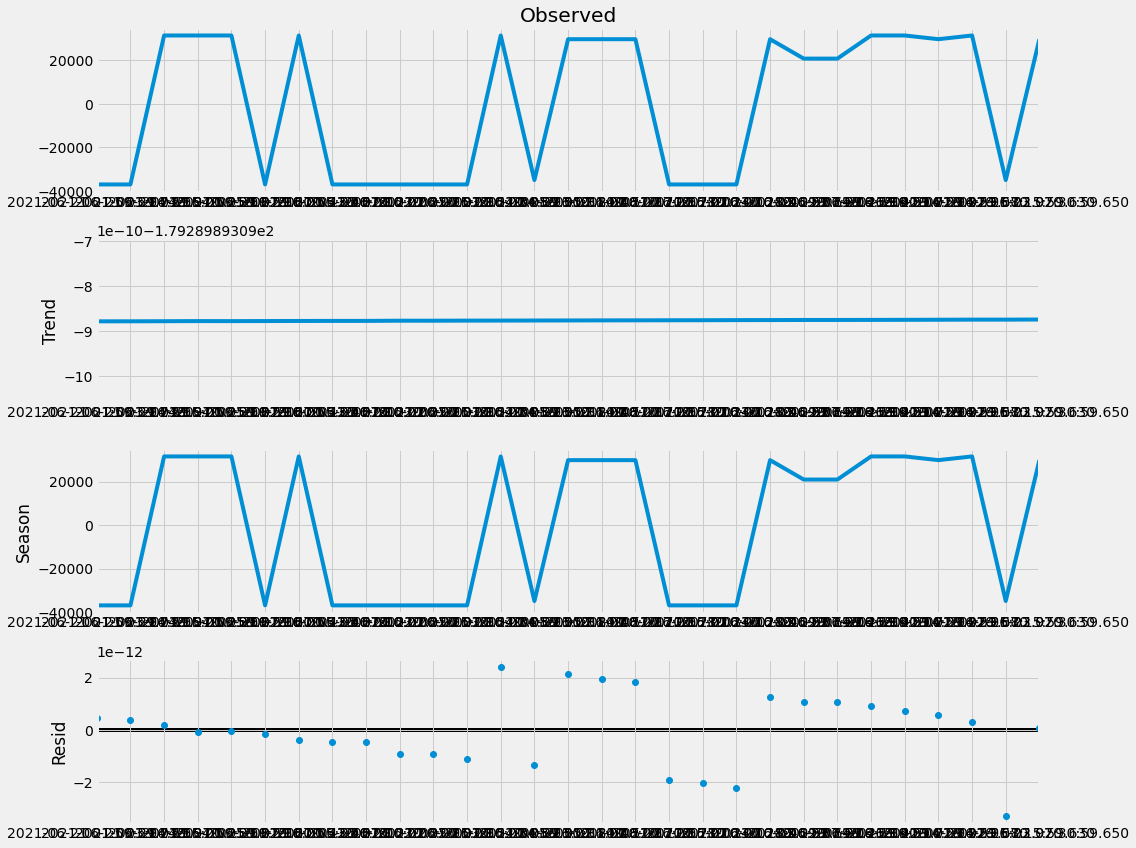

In [16]:
b_stl = STL(dfb_ts_agg, period=52)
res = b_stl.fit()
fig = res.plot()

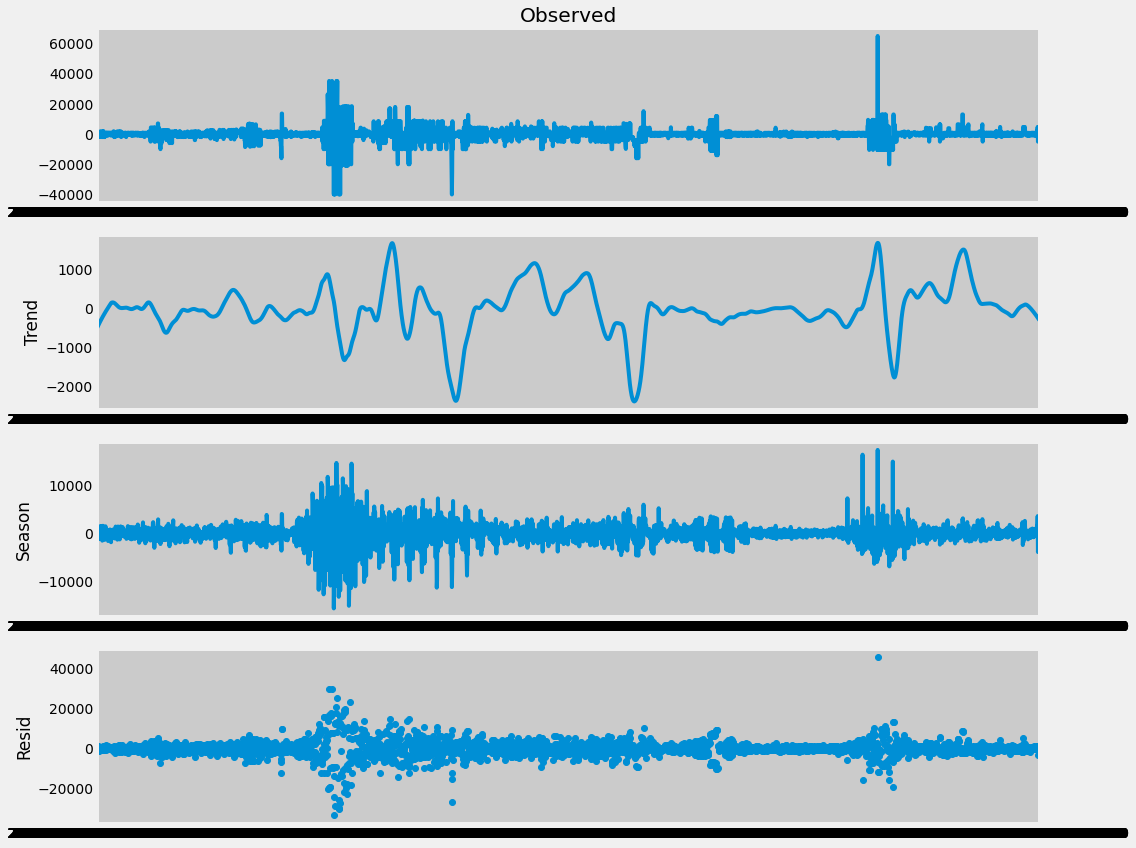

In [17]:
c_stl = STL(dfc_ts_agg, period=52)
res = c_stl.fit()
fig = res.plot()

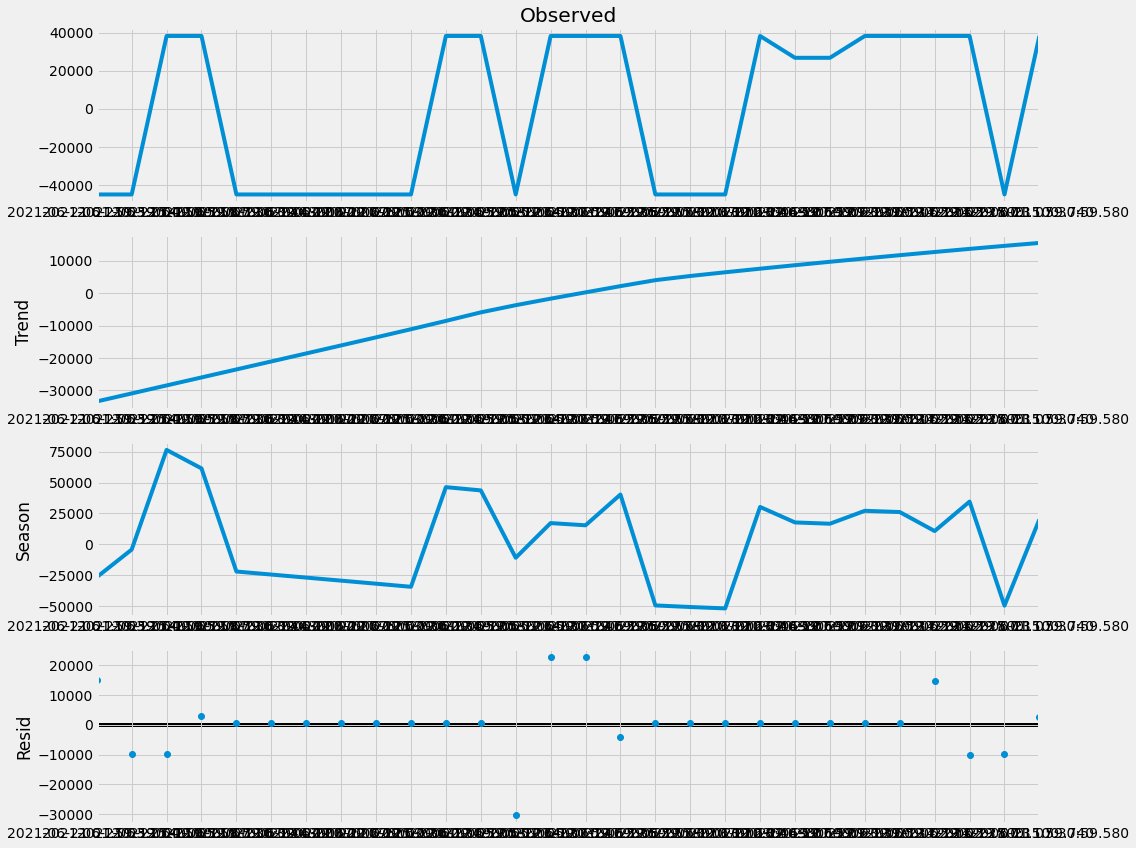

In [18]:
e_stl = STL(dfe_ts_agg, period=12)
res = e_stl.fit()
fig = res.plot()

In [19]:
def tsa_using_stl(data,score_threshold):
    
    output = data.copy()
    
    # Create dataframe columns from decomposition results
    output['residual']= res.resid
    output['trend']= res.trend
    output['seasonal'] = res.seasonal
    output['weights'] = res.weights
    
    #Baseline is generally seasonal + trend 
    output['baseline'] = output['seasonal']+output['trend']
    
    # Type cast and replace na values with 0
    output = output.fillna(0).astype('int64')
    
    # Calculate zscore based on residual column - this column does not contain seasonal/trend components
    output['score'] = stats.zscore(output['residual'])
    
    # create positive and negative columns based on threshold(3) and seasonal components
    output.loc[(output['score'] > score_threshold) & (output['seasonal'] > 0),'anomalies'] = 1
    output.loc[(output['score'] > score_threshold) & (output['seasonal'] < 0),'anomalies'] = -1
    output.loc[(output['score'] < score_threshold),'anomalies'] = 0
    
    #Datatype casting
    #doesn't work with traders A & C
    #output = output.reset_index()
    
    return output

In [20]:
STL_dfa = tsa_using_stl(dfa_ts_agg, 5)
STL_dfc = tsa_using_stl(dfc_ts_agg, 5)

In [21]:
STL_dfb = tsa_using_stl(dfb_ts_agg, 2.5)
STL_dfe = tsa_using_stl(dfe_ts_agg, 2.5)

In [22]:
print(STL_dfa)
print(STL_dfb)
print(STL_dfc)
print(STL_dfe)

               Trading Time  Trader Profit  residual  trend  seasonal  \
0   2021-06-18 01:00:22.690           3862         0      0         0   
1   2021-06-18 01:07:13.110           4269         0      0         0   
2   2021-06-18 01:13:32.950          -4492         0      0         0   
3   2021-06-18 01:18:38.060           4245         0      0         0   
4   2021-06-18 01:27:37.130          -3245         0      0         0   
..                      ...            ...       ...    ...       ...   
95  2021-06-21 08:04:03.010          -3240         0      0         0   
96  2021-06-21 09:02:31.600          -2916         0      0         0   
97  2021-06-21 09:05:43.260          -2116         0      0         0   
98  2021-06-21 09:05:47.910          -1906         0      0         0   
99  2021-06-21 09:15:42.680          -2221         0      0         0   

    weights  baseline  score  anomalies  
0         0         0    NaN        NaN  
1         0         0    NaN        NaN

In [23]:
# Display sample results
STL_dfa['anomalies'].value_counts()

Series([], Name: anomalies, dtype: int64)

In [24]:
STL_dfb['anomalies'].value_counts()

 0.0    28
-1.0     1
Name: anomalies, dtype: int64

In [25]:
STL_dfc['anomalies'].value_counts()

Series([], Name: anomalies, dtype: int64)

In [26]:
STL_dfe['anomalies'].value_counts()

0.0    28
Name: anomalies, dtype: int64

<AxesSubplot:>

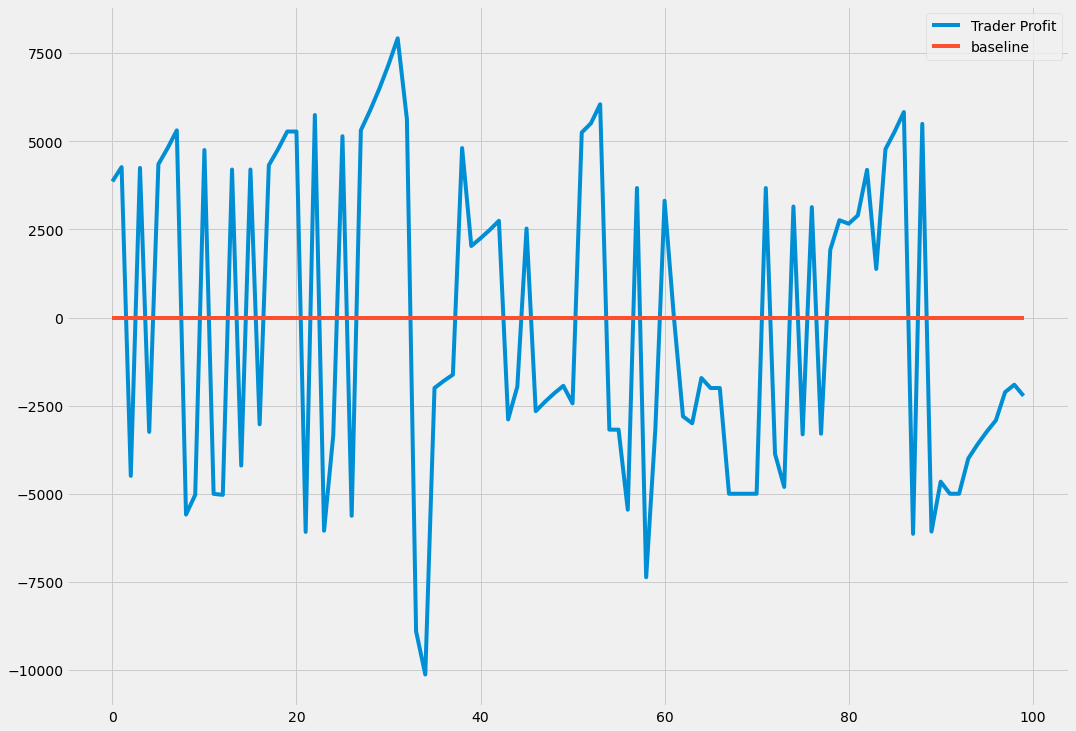

In [27]:
STL_dfa[['Trader Profit', 'baseline']].plot()

<AxesSubplot:>

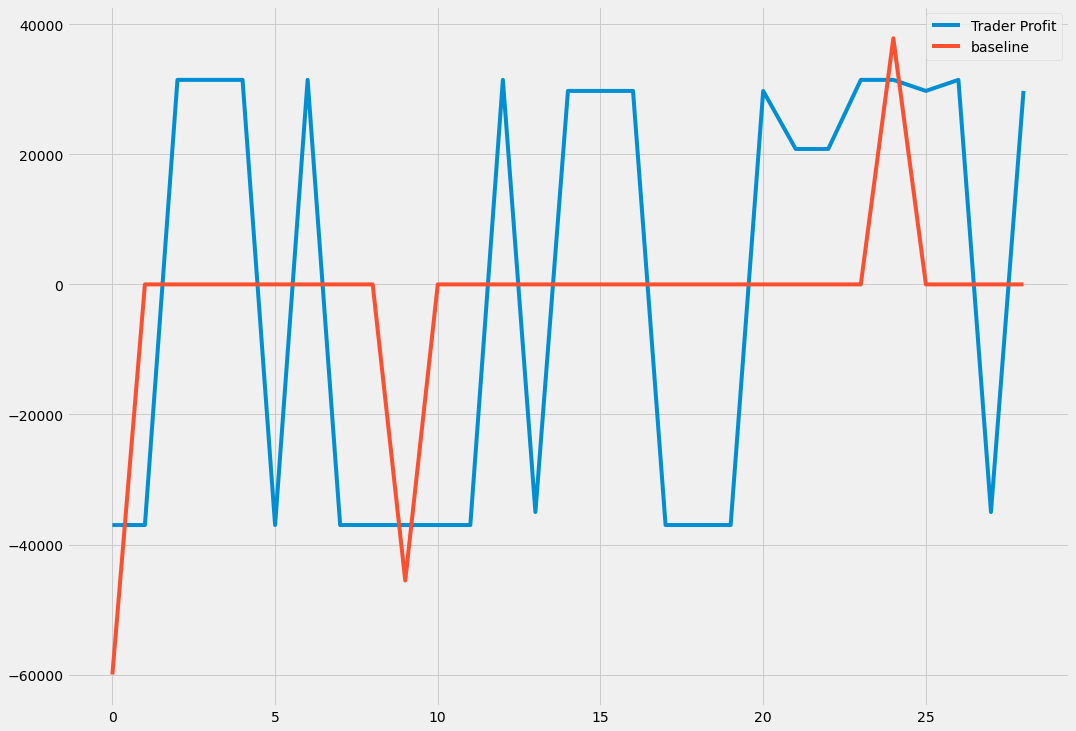

In [28]:
STL_dfb[['Trader Profit', 'baseline']].plot()

<AxesSubplot:>

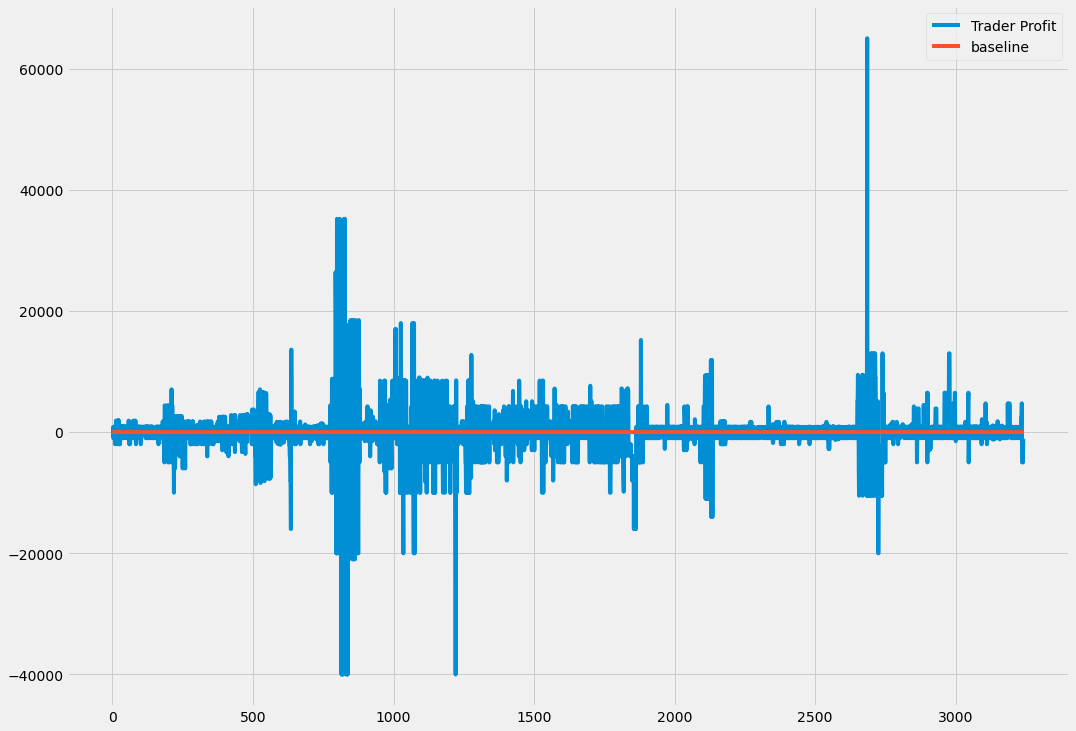

In [29]:
STL_dfc[['Trader Profit', 'baseline']].plot()

<AxesSubplot:>

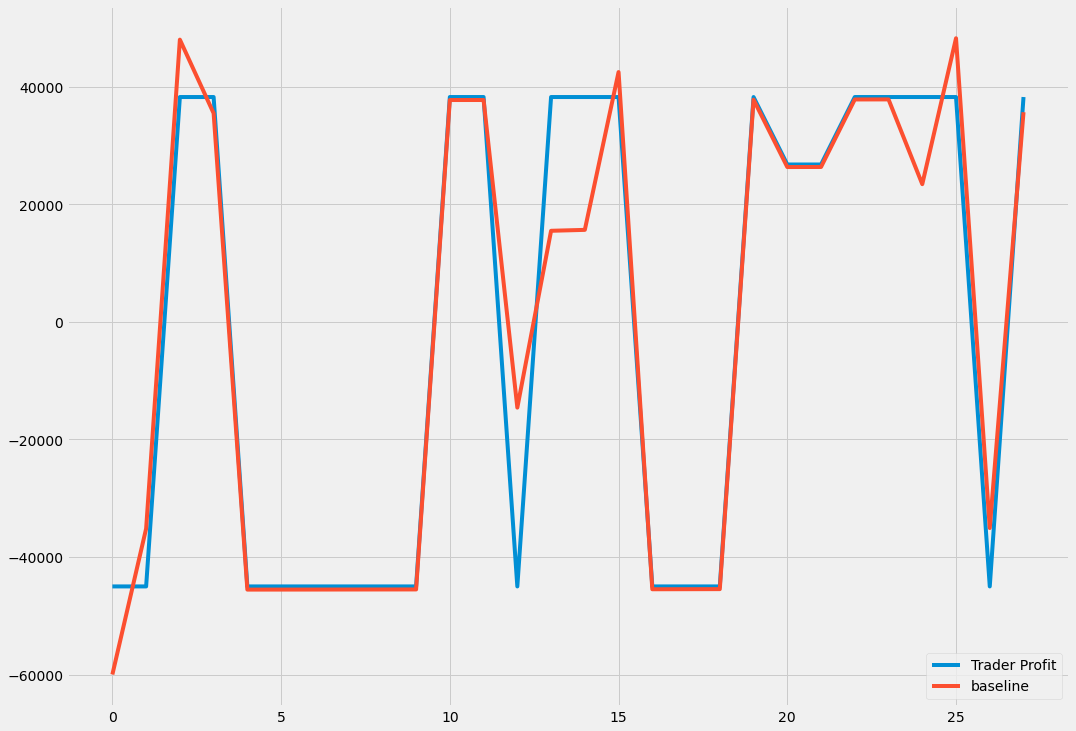

In [30]:
STL_dfe[['Trader Profit', 'baseline']].plot()

In [31]:
# Filter the dataframe and displaying only Flagged anomalies
STL_dfa[STL_dfa['anomalies']==1]

,Trading Time,Trader Profit,residual,trend,seasonal,weights,baseline,score,anomalies


In [32]:
STL_dfb[STL_dfb['anomalies']==1]

,Trading Time,Trader Profit,residual,trend,seasonal,weights,baseline,score,anomalies


In [33]:
STL_dfc[STL_dfc['anomalies']==1]

,Trading Time,Trader Profit,residual,trend,seasonal,weights,baseline,score,anomalies


In [34]:
STL_dfe[STL_dfe['anomalies']==1]

,Trading Time,Trader Profit,residual,trend,seasonal,weights,baseline,score,anomalies


In [35]:
STL_dfa['Trading Time'] = STL_dfa['Trading Time'].apply(lambda x : str(x)[:-12])
STL_dfb['Trading Time'] = STL_dfb['Trading Time'].apply(lambda x : str(x)[:-12])
STL_dfc['Trading Time'] = STL_dfc['Trading Time'].apply(lambda x : str(x)[:-12])
STL_dfe['Trading Time'] = STL_dfe['Trading Time'].apply(lambda x : str(x)[:-12])

In [36]:
STL_dfa['Trading Time'] = pd.to_datetime(STL_dfa['Trading Time'])
STL_dfb['Trading Time'] = pd.to_datetime(STL_dfb['Trading Time'])
STL_dfc['Trading Time'] = pd.to_datetime(STL_dfc['Trading Time'])
STL_dfe['Trading Time'] = pd.to_datetime(STL_dfe['Trading Time'])

In [37]:
timeseries_anomalies_plot = display_timeseries_anomolies(data=STL_dfa, y="Trader Profit",time_column='Trading Time')

Loading BokehJS ...

In [38]:
timeseries_anomalies_plot = display_timeseries_anomolies(data=STL_dfb, y="Trader Profit",time_column='Trading Time')

Loading BokehJS ...

In [39]:
timeseries_anomalies_plot = display_timeseries_anomolies(data=STL_dfc, y="Trader Profit",time_column='Trading Time')

Loading BokehJS ...

In [40]:
timeseries_anomalies_plot = display_timeseries_anomolies(data=STL_dfe, y="Trader Profit",time_column='Trading Time')

Loading BokehJS ...